# Aktuelle Feuerbeobachtungen weltweit

## Hier stellen wir ein, für welchen Zeitraum wir Daten holen und von welchem Satellit.

In [1]:
zeitraum      = '7d'        # Standard: '24h'; alternativ: '48h' oder '7d' 
feuersatellit = 'SUOMI_VIIRS'      # Standard: 'MODIS'; alternativ: 'J1_VIIRS' oder 'SUOMI_VIIRS'

## Vorbereitung: Lade Apps und die Feuerdaten.


Wir werden in der Programmiersprache Python arbeiten, um Satellitenbeobachtungen von Feuern zu betrachten. 
Wir arbeiten dabei in diesem Notebook. Das Notebook besteht aus Zellen, die einzeln angeklickt werden können: 
*  numerierte Zellen (\[1\], \[2\], \[3\]...) enthalten ausführbaren Python Code, d.h. Befehle, die der Computer ausführen soll. Oben in der Leiste seht ihr Code eingeblendet.
* nicht-nummerierte Zellen enthalten entweder Kommentare oder die Ausgabe von ausgeführtem Code. Oben in der Leiste sehr ihr Markdown eingeblendet. 

### Importiere Python-Apps.
Als erstes müssen wir dafür verschiedene "Python-Apps" importieren, mit denen wir arbeiten wollen. Das erfolgt mit dem Befehl import.

_Hier laden wir vorinstallierte Apps._

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import cmasher as cmr
import json
import requests
from zipfile import ZipFile
from io import BytesIO

_Hier stellen wir ein, wie in den Notebookzellen alle Ergebnisse dargestellt werden._

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Hole Dir die Feuerbeobachtungen der letzten 24 Stunden.

Das machst Du mit dem Befehl !wget, gefolgt von der Internetadresse. 
Als Internetadresse gibst Du das FIRMS NASA Datenarchiv an. FIRMS stellt Satellitenfeuerbeobachtungen von MODIS und VIIRS in nahezu Echtzeit ("NRT" near-realtime) zur Verfügung. NRT bedeutet dabei, dass die Satellitendaten innerhalb von 3 Stunden nach der eigentlichen Aufnahme zur Verfügung gestellt werden.  
Wir holen uns die Feuerbeobachtungen als csv-Datei. csv bedeutet "comma separated value", d.h. es ist eine Tabelle, in der die einzelnen Werte mit Kommas getrennt sind. 

_Hier suchen wir uns die richtige Internetadresse für die Satellitendaten raus.<br>_
_Wir arbeiten in erster Linie mit MODIS._

In [4]:
if feuersatellit   == 'MODIS':
    datei           = 'MODIS_C6_1_Global_'+zeitraum+'.csv'
    internetadresse = 'https://firms.modaps.eosdis.nasa.gov/data/active_fire/modis-c6.1/csv/'+datei
elif feuersatellit == 'SUOMI_VIIRS':
    datei           = 'SUOMI_VIIRS_C2_Global_'+zeitraum+'.csv'
    internetadresse = 'https://firms.modaps.eosdis.nasa.gov/data/active_fire/suomi-npp-viirs-c2/csv/'+datei
elif feuersatellit == 'J1_VIIRS':
    datei           = 'J1_VIIRS_C2_Global_'+zeitraum+'.csv'
    internetadresse = 'https://firms.modaps.eosdis.nasa.gov/data/active_fire/noaa-20-viirs-c2/csv/'+datei

_Hiermit holen wir uns unsere Satellitendaten von NASA und speichern sie als *.csv Datei auf unserem Computer._

In [5]:
!wget -N {internetadresse}

--2022-05-06 11:05:59--  https://firms.modaps.eosdis.nasa.gov/data/active_fire/suomi-npp-viirs-c2/csv/SUOMI_VIIRS_C2_Global_7d.csv
Auflösen des Hostnamens firms.modaps.eosdis.nasa.gov (firms.modaps.eosdis.nasa.gov)… 2001:4d0:241a:40c0::34, 198.118.194.34
Verbindungsaufbau zu firms.modaps.eosdis.nasa.gov (firms.modaps.eosdis.nasa.gov)|2001:4d0:241a:40c0::34|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 19768700 (19M) [text/csv]
Wird in »SUOMI_VIIRS_C2_Global_7d.csv« gespeichert.

SUOMI_VIIRS_C2_Glob 100%[===================>]  18,85M  13,6MB/s    in 1,4s    

2022-05-06 11:06:01 (13,6 MB/s) - »SUOMI_VIIRS_C2_Global_7d.csv« gespeichert [19768700/19768700]



In [6]:
# wir schauen die ersten 6 Zeilen der heruntergeladenen Datei
!head -6 {datei}

latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,confidence,version,bright_ti5,frp,daynight
40.44518,27.13385,318,0.47,0.4,2022-04-29,0024,N,nominal,2.0NRT,286.76,2.55,N
41.50226,19.74171,295.62,0.43,0.38,2022-04-29,0024,N,nominal,2.0NRT,282.92,0.61,N
39.4849,30.04271,312.26,0.44,0.46,2022-04-29,0024,N,nominal,2.0NRT,283.04,1.15,N
39.86645,26.24398,310.83,0.45,0.39,2022-04-29,0024,N,nominal,2.0NRT,286.44,1.53,N
40.28522,23.44633,298.53,0.39,0.36,2022-04-29,0024,N,nominal,2.0NRT,285.96,0.39,N


## Lesen der Feuerdaten in die pandas App und Inspektion

### Speichere die Feuerbeobachtungen in der Variable feuerdaten

In [7]:
# Dafür nutzen wir den Befehl read_csv. 
feuerdaten = pd.read_csv(datei)

### Wie sehen die ersten 5 Zeilen aus?

Wir sehen eine Überschriftzeile, jede Spalte hat eine Überschrift. Weiterhin sehen wir vier Zeilen mit Werten. Jede Zeile bedeutet ein Feuerpixel. <br>
Für uns sind folgende Spalten wichtig:
* latitude: der Breitengrad, also wieviel Grad Süd oder Nord. Negativ Werte bedeuten Süden. 
* longitude: der Längengrad, also wieviel Grad West oder Ost. Negative Werte bedeuten Westen.<br> 
Zur Info: Hamburg befindet sich 53.55°N und 10.00° E, d.h. latitude=53.55 und longitude=10.00.

Weiterhin ist für uns wichtig:
* acq_date: das Datum, an dem die Beobachtung gemacht wurde. 2022 ist das Jahr, 04 steht für den Monat April.
* acq_time: die Uhrzeit der Beobachtung. Die Schreibweise ist HHMM, wobei HH die Stunde und MM die Minuten bedeuten. <br>
Zur Info: Datum und Uhrzeit sind in der UTC (Coordinated Universal Time) Zeit angeben. Um die aktuelle Uhrzeit in Deutschland zu berechnen, musst Du 2 Stunden addieren. 

Hilfreich ist zudem:
* frp: die Feuer-Strahlungsleistung (fire radiative power, FRP) in Megawatt \[MW\], ein Indikator für die Feuerintensität




In [8]:
feuerdaten.head(5)

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,confidence,version,bright_ti5,frp,daynight
0,40.44518,27.13385,318.00,0.47,0.40,2022-04-29,24,N,nominal,2.0NRT,286.76,2.55,N
1,41.50226,19.74171,295.62,0.43,0.38,2022-04-29,24,N,nominal,2.0NRT,282.92,0.61,N
2,39.48490,30.04271,312.26,0.44,0.46,2022-04-29,24,N,nominal,2.0NRT,283.04,1.15,N
3,39.86645,26.24398,310.83,0.45,0.39,2022-04-29,24,N,nominal,2.0NRT,286.44,1.53,N
4,40.28522,23.44633,298.53,0.39,0.36,2022-04-29,24,N,nominal,2.0NRT,285.96,0.39,N


### Aufbereitung der Daten auf, so dass wir damit besser arbeiten können 

1) Wir beschränken uns auf die Variablen, die für uns relevant sind
2) Wir wandeln Datum und Zeit in ein besser lesbares Format um, und so, dass es sich auf die deutsche Zeitzone bezieht.
3) Wir benennen die Überschriften um

In [9]:
feuerdaten = feuerdaten.set_index((pd.to_datetime(feuerdaten['acq_date'] + 
                                                  ' ' + feuerdaten['acq_time'].astype(str).str.zfill(4).str.wrap(2).str.replace('\n', ':'))) 
                                                      + pd.DateOffset(hours=2))
feuerdaten.index.name = 'Beobachtungszeit'
feuerdaten = feuerdaten[['latitude', 'longitude', 'frp']].rename(columns={'latitude': 'Breitengrad', 'longitude':'Längengrad', 'frp': 'Feuerintensität'})

### Jetzt schauen wir uns die aufbereiteten Daten genauer an!

In [10]:
#### Wann wurden die letzten Feuer beobachtet?

In [11]:
feuerdaten.sort_index(ascending=False).head(5)

,Breitengrad,Längengrad,Feuerintensität
Beobachtungszeit,,,
2022-05-06 08:05:00,21.50832,98.65786,14.67
2022-05-06 08:05:00,23.61991,111.46503,8.18
2022-05-06 08:05:00,22.81523,115.84289,4.10
2022-05-06 08:05:00,22.81305,115.84506,3.88
2022-05-06 08:05:00,22.81272,115.84148,2.46


#### Wieviele Feuer wurden weltweit beobachtet?

In [12]:
len(feuerdaten)

242935

#### Welche Strahlungleistung erzeugten die Feuer (in Megawatt)?
1 MW enspricht einer Millionen Watt! D.h. 1000 MW ensprechen einer Milliarden Watt! 

In [13]:
print(int(feuerdaten['Feuerintensität'].sum()),'MW') 

2137180 MW


#### Wieviel Watt pro Mensch auf dieser Erde (8 Millarden Menschen derzeit) entspricht das?

In [14]:
print(int((feuerdaten['Feuerintensität'].sum()*1.e+6)/8.e+9), 'Watt')

267 Watt


## Wo wurden die Feuer beobachtet? Wir erstellen eine Weltkarte.

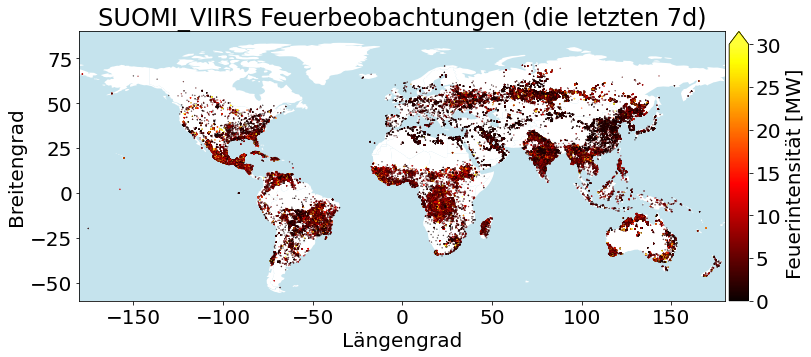

In [15]:
rahmen, bild1 = plt.subplots(figsize=(12,6))
# Jetzt zeichnen wir eine Weltkarte in grau
landkarte  = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
landbild1  = landkarte.plot(color='white', ax=bild1)
bild1.patch.set_facecolor('lightblue')
bild1.patch.set_alpha(0.7)
# Jetzt zeichnen wir die Feuer in die Weltkarte. 
# Besonders intensive Feuer erscheinen in gelb, schwache Feuer erscheinen in dunkelrot/schwarz.
# vmax wird so gewählt, dass in etwa 95% aller Werte kleiner als vmax sind (95% Perzentilwert, gerundet auf voll 5er) 
vmin, vmax = 0, 5*round(np.percentile(feuerdaten['Feuerintensität'],95)/5)
cmap = cmr.get_sub_cmap('hot', 0, 0.8)
feuerbild1 = feuerdaten.plot(x='Längengrad', y='Breitengrad', kind='scatter', c='Feuerintensität', alpha=1,
        cmap=cmap, s=0.1, vmin=vmin, vmax=vmax, ax=bild1, colorbar=False, 
        title=feuersatellit+' Feuerbeobachtungen (die letzten '+zeitraum+')')

# Nun machen wir den Farbbalken
norm   = mpl.colors.Normalize(vmin=vmin, vmax=vmax); divider = make_axes_locatable(bild1)
cax    = divider.append_axes('right', size='3%', pad=0.05)
stdout = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='max', label='Feuerintensität [MW]')

# Hier bestimmen wir, welche Region auf der Weltkarte gezeigt wird und die Axenbeschriftung.
stdout = bild1.set_xlim(-180,180)
stdout = bild1.set_ylim(-60,90)
stdout = bild1.set_xlabel('Längengrad')
stdout = bild1.set_ylabel('Breitengrad')

## Wo wurden die Feuer in Deutschland oder in einem anderen Land beobachtet?

Als erstes holen wir uns die geogaphischen Eckpunkte von den Ländern der Welt. <br />
Dann holen wir uns eine Weltkarte, die die Ländergrenzen genauer darstellt als Standard-Länderkarte von geopandas (naturalearth_lowres) <br />
Weiterhin holen wir uns einen Datensatz, die Koordinaten von größeren Städten (> 50.000 Einwohner) enthält  <br />https://gist.githubusercontent.com/curran/13d30e855d48cdd6f22acdf0afe27286/raw/0635f14817ec634833bb904a47594cc2f5f9dbf8/worldcities_clean.csv


In [16]:
URL                  = 'https://github.com/geobase/countries/releases/download/1.0.5/countries.zip'
with ZipFile(BytesIO(requests.get(URL).content), "r") as f:
    countries_json = f.extract('countries.json')
laender_bounds     =  pd.read_json(countries_json)
laender_bounds_tmp = pd.DataFrame(columns=['en_country','de_country'])
for (i,r) in laender_bounds.iterrows():
    name_dict = r['names']
    laender_bounds_tmp.loc[i] = [name_dict['en'], name_dict['de']]
laender_bounds = pd.concat([laender_bounds, laender_bounds_tmp], axis=1).drop(columns=['names', 'currency', 'timezone', 'population', 'capital', 'area'])

In [17]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
URL                  = 'https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/download/?format=kml&timezone=Europe/Berlin&lang=en'
laendergrenzen       = gpd.read_file(URL, driver='KML')

URL                  = 'https://gist.githubusercontent.com/curran/13d30e855d48cdd6f22acdf0afe27286/raw/0635f14817ec634833bb904a47594cc2f5f9dbf8/worldcities_clean.csv'
city_coords          = pd.read_csv(URL) 

## Wo wurden die Feuer in einem speziellen Land beobachtet? Wir erstellen eine Karte....

Du kannst hier aber auch ein beliebig anderes Land wählen!

In [21]:
land       = 'Ukraine'         #-- deutsche Schreibweise

In [22]:
# Hier definieren wir die Eckkordinaten unserer Domain (das erfolgt automatisch über die bounds)

country       = laender_bounds[laender_bounds['de_country'] == land]['en_country'].item()
country_ISO   = laender_bounds[laender_bounds['de_country'] == land]['code'].item()
domain_koord  = laender_bounds[laender_bounds['de_country'] == land].values.flatten()[5:9][[3,2,1,0]] # longmin, latmin, longmax, latmax
# Eine Alternative, wenn obige domain_koord unsinnige Bounds ergeben
#r = requests.get(r"http://nominatim.openstreetmap.org/search?q=%s&format=json"%country)
#domain_koord2  = np.asarray([float(i) for i in json.loads(r.text)[0]["boundingbox"]])[[2,0,3,1]]

# Wir holen uns genaue Länderkarten mit Distrikten
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
gadm_lev0      = 'gadm40_'+country_ISO+'_0'
r              = requests.get('https://geodata.ucdavis.edu/gadm/gadm4.0/kmz/'+gadm_lev0+'.kmz')
zf             = ZipFile(BytesIO(r.content))
country_bounds = gpd.read_file(zf.open(gadm_lev0+'.kml'), driver='KML')
gadm_lev1      = 'gadm40_'+country_ISO+'_1'
r              = requests.get('https://geodata.ucdavis.edu/gadm/gadm4.0/kmz/'+gadm_lev1+'.kmz')
zf             = ZipFile(BytesIO(r.content))
districts      = gpd.read_file(zf.open(gadm_lev1+'.kml'), driver='KML')

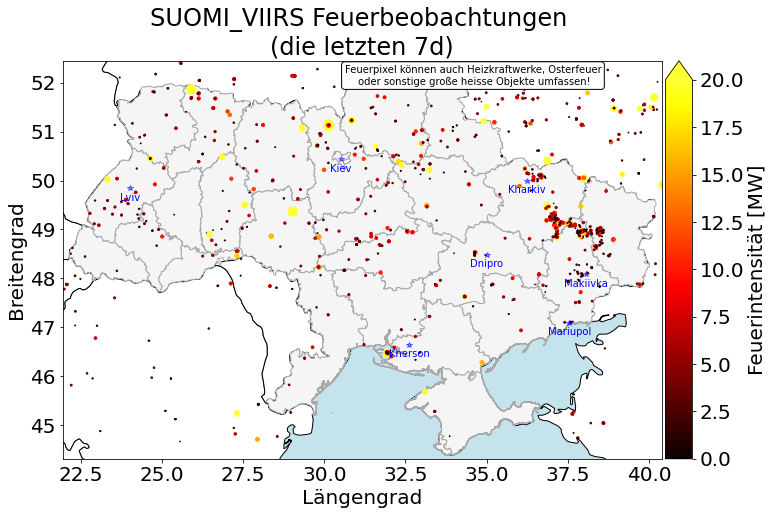

In [23]:
# Wir machen einen Bilderrahmen und sagen, wie groß das Bild darin sein soll.
rahmen, bild = plt.subplots(figsize=(14,18))

# Nun machen wir eine Karte mit den Ländergrenzen und den Districtgrenzen Wasserflächen werden hellblau dargestellt.

_ = laendergrenzen.plot(color='white', edgecolor='black', linewidth=1, ax=bild) # aspect=None)
_ = districts.plot(color='whitesmoke', edgecolor='darkgrey', linewidth=1, ax=bild) # aspect=None)
_ = bild.patch.set_facecolor('lightblue'); _ = bild.patch.set_alpha(0.7)
# Wir limitieren die Darstellung der Karte auf die Region des ausgewählten Landes.
# Wir machen die Region an den Seiten ein wenig größer, damit die Löndergrenze nicht am Bildrand ist. 
# Dafür berechnen wir die Differenz der Eckpunkte. 
diff_lat= domain_koord[3] - domain_koord[1]; diff_lon = domain_koord[2] - domain_koord[0]
_ = bild.set_xlim(-0.01*  diff_lon + domain_koord[0], 0.01*  diff_lon + domain_koord[2])
_ = bild.set_ylim(-0.01*  diff_lat + domain_koord[1], 0.01*  diff_lat + domain_koord[3])
_ = bild.set_xlabel('Längengrad'); _ = bild.set_ylabel('Breitengrad');

# Jetzt zeichnen wir die Feuer in die Karte. 
# Intensive Feuer erscheinen in gelb, schwache Feuer erscheinen in dunkelrot/schwarz.
# Intensivere Feuer haben größere Markerpunkte als schwache Feuer.
# Jetzt müssen wir die Farbskala skalieren, so dass das Maximum der Feuerstärke dem 90 Percentil-FRP-wert 
# für die gezeigte Domain entspricht
vmin, vmax = 0, 5*round(np.percentile(feuerdaten[feuerdaten['Längengrad'].between(domain_koord[0],domain_koord[2]) &
                feuerdaten['Breitengrad'].between(domain_koord[1],domain_koord[3])]['Feuerintensität'],95)/5)

feuerbild = feuerdaten.plot(x='Längengrad', y='Breitengrad', kind='scatter', c='Feuerintensität',
             colormap=cmap, colorbar=False, s='Feuerintensität', vmin=vmin, vmax=vmax, ax=bild,  
             title=feuersatellit+' Feuerbeobachtungen \n(die letzten '+zeitraum+')')

# Hiermit zeichnen wir einige große Städe ein.
major_cities       = city_coords[(city_coords['population'] > 1.e+6) & (city_coords['country']==country)]
for index, city in major_cities.iterrows():
    # Plot city name
    _ = bild.text(city['lng'], city['lat'] - 0.25, s = city['city'], c = 'blue', fontsize=10, ha='center')
    # Plot city location centroid.
    _ = bild.plot(city['lng'], city['lat'], marker='*', c='blue', alpha=0.5)

# Hier ergänzen wir einige Städte, die relevant sind im Ukrainekrieg 2022
if country == 'Ukraine':
    other_cities = {
    'Mariupol': (37.549444,47.095833 ), 
    'Lviv': (24.032222, 49.8425),
    'Makiivka': (38.066667, 48.083333),
    'Kherson': (32.625, 46.6425)}
    for c in other_cities.keys():
        bild.text(x=other_cities[c][0], y=other_cities[c][1] - 0.25, s=c, c='blue', fontsize=10, ha='center')
        bild.plot(other_cities[c][0], other_cities[c][1], marker='*', c='blue', alpha=0.5)
    
# Nun machen wir den Farbbalken.
norm  = mpl.colors.Normalize(vmin=vmin, vmax=vmax); divider = make_axes_locatable(bild)
cax   = divider.append_axes('right', size='3%', pad=-2.05)
_     = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='max', label='Feuerintensität [MW]')
    
# Nun machen wir noch eine kleine Textbox mit einer Anmerkung.
_     = bild.annotate('Feuerpixel können auch Heizkraftwerke, Osterfeuer\n oder sonstige große heisse Objekte umfassen!',
               xy=(0.685, 0.99), fontsize=10, xycoords='axes fraction', ha="center", va="top", 
               bbox=dict(boxstyle='round', fc='w'));



## Wie sieht die aktuelle Kriegslage in der Ukraine aus?

<div>
   <img src="https://www.understandingwar.org/sites/default/files/DraftUkraineCoTMay05%2C2022.png" width="600">
</div>